# Preparing to start 
### 1) Loading packages

In [80]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

from itertools import product
import gc

from sklearn import preprocessing
import sklearn
import xgboost as xgb

In [75]:
from scipy.stats.stats import pearsonr  
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, median_absolute_error

**`Sales Training, Test & Validation Data Set`**

In [47]:
data = pd.read_csv('D:\\DC Universe\\Ucsc\\Third Year\\SCS 3201 Machine Learning\\DataStorm\\train_data.csv')
test= pd.read_csv('D:\\DC Universe\\Ucsc\\Third Year\\SCS 3201 Machine Learning\\DataStorm\\test_data.csv')
validate= pd.read_csv('D:\\DC Universe\\Ucsc\\Third Year\\SCS 3201 Machine Learning\\DataStorm\\validation_data.csv')

# **Explore the Sales data frame**
`Doing a comprehensive exploration of this Data.`

**1) Training DataSet**

In [3]:
data.head(5)

,CategoryCode,ItemCode,DateID,DailySales
0,category_2,117610,11/6/2021,7
1,category_4,836584,11/18/2021,16
2,category_1,370195,1/24/2022,6
3,category_2,172582,10/30/2021,5
4,category_2,1006009,10/30/2021,5


In [4]:
# creating a dataframe using dictionary
df = pd.DataFrame(data)
  
# using notnull() function 
df.notnull().sum()

CategoryCode    19921
ItemCode        19921
DateID          19921
DailySales      19921
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.dtypes

CategoryCode    object
ItemCode         int64
DateID          object
DailySales       int64
dtype: object

**2) Test DataSet**

In [11]:
test.head(5)

,CategoryCode,ItemCode,Week,PredictedSales
0,category_1,43738,w4,NaN
1,category_2,1006090,w1,NaN
2,category_2,1076929,w4,NaN
3,category_1,1081321,w3,NaN
4,category_2,216151,w4,NaN


In [12]:
test.dtypes

CategoryCode       object
ItemCode            int64
Week               object
PredictedSales    float64
dtype: object

**3) Validation DataSet**

In [14]:
validate.head(5)

,CategoryCode,ItemCode,Week,WeeklySales
0,category_2,1044502,w1,11
1,category_2,1105009,w1,11
2,category_2,913561,w4,5
3,category_1,1048975,w4,30
4,category_1,17287,w2,60


In [15]:
validate.dtypes

CategoryCode    object
ItemCode         int64
Week            object
WeeklySales      int64
dtype: object

In [16]:
data.columns

Index(['CategoryCode', 'ItemCode', 'DateID', 'DailySales'], dtype='object')

## How can we generate forecasts for grouped Sales Items? 

**Our training data consists of 19921 timeseries.**

`Unit sales of product x, aggregated for each Weekly Sales.`
A simple method to generate forecasts for all levels is to focus only on the bottom level. All of its predictions are then summed up to create the forecasts of all levels up to the top. This is called the bottom-up approach.

In [17]:
trained= data.groupby(['CategoryCode','ItemCode'],axis="rows")

In [18]:
trained.head(5)

,CategoryCode,ItemCode,DateID,DailySales
0,category_2,117610,11/6/2021,7
1,category_4,836584,11/18/2021,16
2,category_1,370195,1/24/2022,6
3,category_2,172582,10/30/2021,5
4,category_2,1006009,10/30/2021,5
...,...,...,...,...
2069,category_2,1006099,10/3/2021,2
2331,category_2,111436,10/21/2021,2
2571,category_1,1090114,10/8/2021,2
2821,category_1,1090294,10/8/2021,3


In [19]:
data.DateID = pd.to_datetime(data.DateID, format='%m/%d/%Y')

In [20]:
data.head(4)

,CategoryCode,ItemCode,DateID,DailySales
0,category_2,117610,2021-11-06,7
1,category_4,836584,2021-11-18,16
2,category_1,370195,2022-01-24,6
3,category_2,172582,2021-10-30,5


In [21]:
dateuni=data.DateID.unique()

## Weekly Sales for Each Sales 

In this Code Segment, We are Segregating Items in Each day Sales. This will help us to find weekly Sales.

In [7]:
import csv,datetime
input={}
weeklySales={}

def getWeek(date):
    year=int(date.split("/")[2])
    day=int(date.split("/")[1])
    month=int(date.split("/")[0])
    weekNo=datetime.date(year, month, day).isocalendar()[1]
    return str(year)+"_"+str(weekNo)

with open('D:\\DC Universe\\Ucsc\\Third Year\\SCS 3201 Machine Learning\\DataStorm\\train_data.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        itemCode=row[1]
        if not itemCode == "ItemCode":
            category=row[0]
            date=row[2]
            sales=row[3]
            week=getWeek(date)
            if input.get(week) == None:
                input[week] = {itemCode:{"category":category,"sales":sales}}
            else:
                if input[week].get(itemCode) == None:
                    input[week][itemCode]={"category":category,"sales":sales}
                else:
                    existing=input[week][itemCode]["sales"]
                    totalSalesQty=int(existing)+int(sales)
                    input[week][itemCode]["sales"]=totalSalesQty

In [ ]:
with open('output.csv','w' ,newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['CategoryCode','ItemCode','Week','WeeklySales'])
    for key in input.keys():
        products=input[key]
        for productId in products:
            product=input[key][productId]
            writer.writerow([product["category"],productId,key,product["sales"]])

In [22]:
dateuni = pd.DataFrame(dateuni, columns = ['UniqueDate'])

In [23]:
dateuni=dateuni.sort_values(by='UniqueDate', ascending=True)

In [24]:
dateuni=dateuni.reset_index()

In [25]:
del dateuni["index"]

In [26]:
dateuni

,UniqueDate
0,2021-10-01
1,2021-10-02
2,2021-10-03
3,2021-10-04
4,2021-10-05
...,...
131,2022-02-09
132,2022-02-10
133,2022-02-11
134,2022-02-12


In [27]:
outTrain= pd.read_csv('D:\\DC Universe\\Ucsc\\Third Year\\SCS 3201 Machine Learning\\DataStorm\\output.csv')

In [28]:
outTrain.head(10)

,CategoryCode,ItemCode,Week,WeeklySales
0,category_2,117610,2021_44,65
1,category_2,1067092,2021_44,204
2,category_2,815101,2021_44,18
3,category_2,172033,2021_44,178
4,category_2,1067074,2021_44,32
5,category_2,1071106,2021_44,25
6,category_2,30877,2021_44,72
7,category_2,877624,2021_44,31
8,category_2,1098493,2021_44,12
9,category_1,1048975,2021_44,8


In [29]:
from sklearn.decomposition import PCA

In [30]:
del outTrain["CategoryCode"]

In [31]:
outTrain.head(10)

,ItemCode,Week,WeeklySales
0,117610,2021_44,65
1,1067092,2021_44,204
2,815101,2021_44,18
3,172033,2021_44,178
4,1067074,2021_44,32
5,1071106,2021_44,25
6,30877,2021_44,72
7,877624,2021_44,31
8,1098493,2021_44,12
9,1048975,2021_44,8


`There are 21 different items.Each Item has Weekly Sales`

In [32]:
outTrain["Week"].nunique()

21

`There are 194 different items.Each Item has Weekly Sales`

In [33]:
outTrain["ItemCode"].nunique()

194

## Data Visualization

### 1) Weeks vs Number of Total Sales

**In order to grasp most demanded Weeks for Sales**


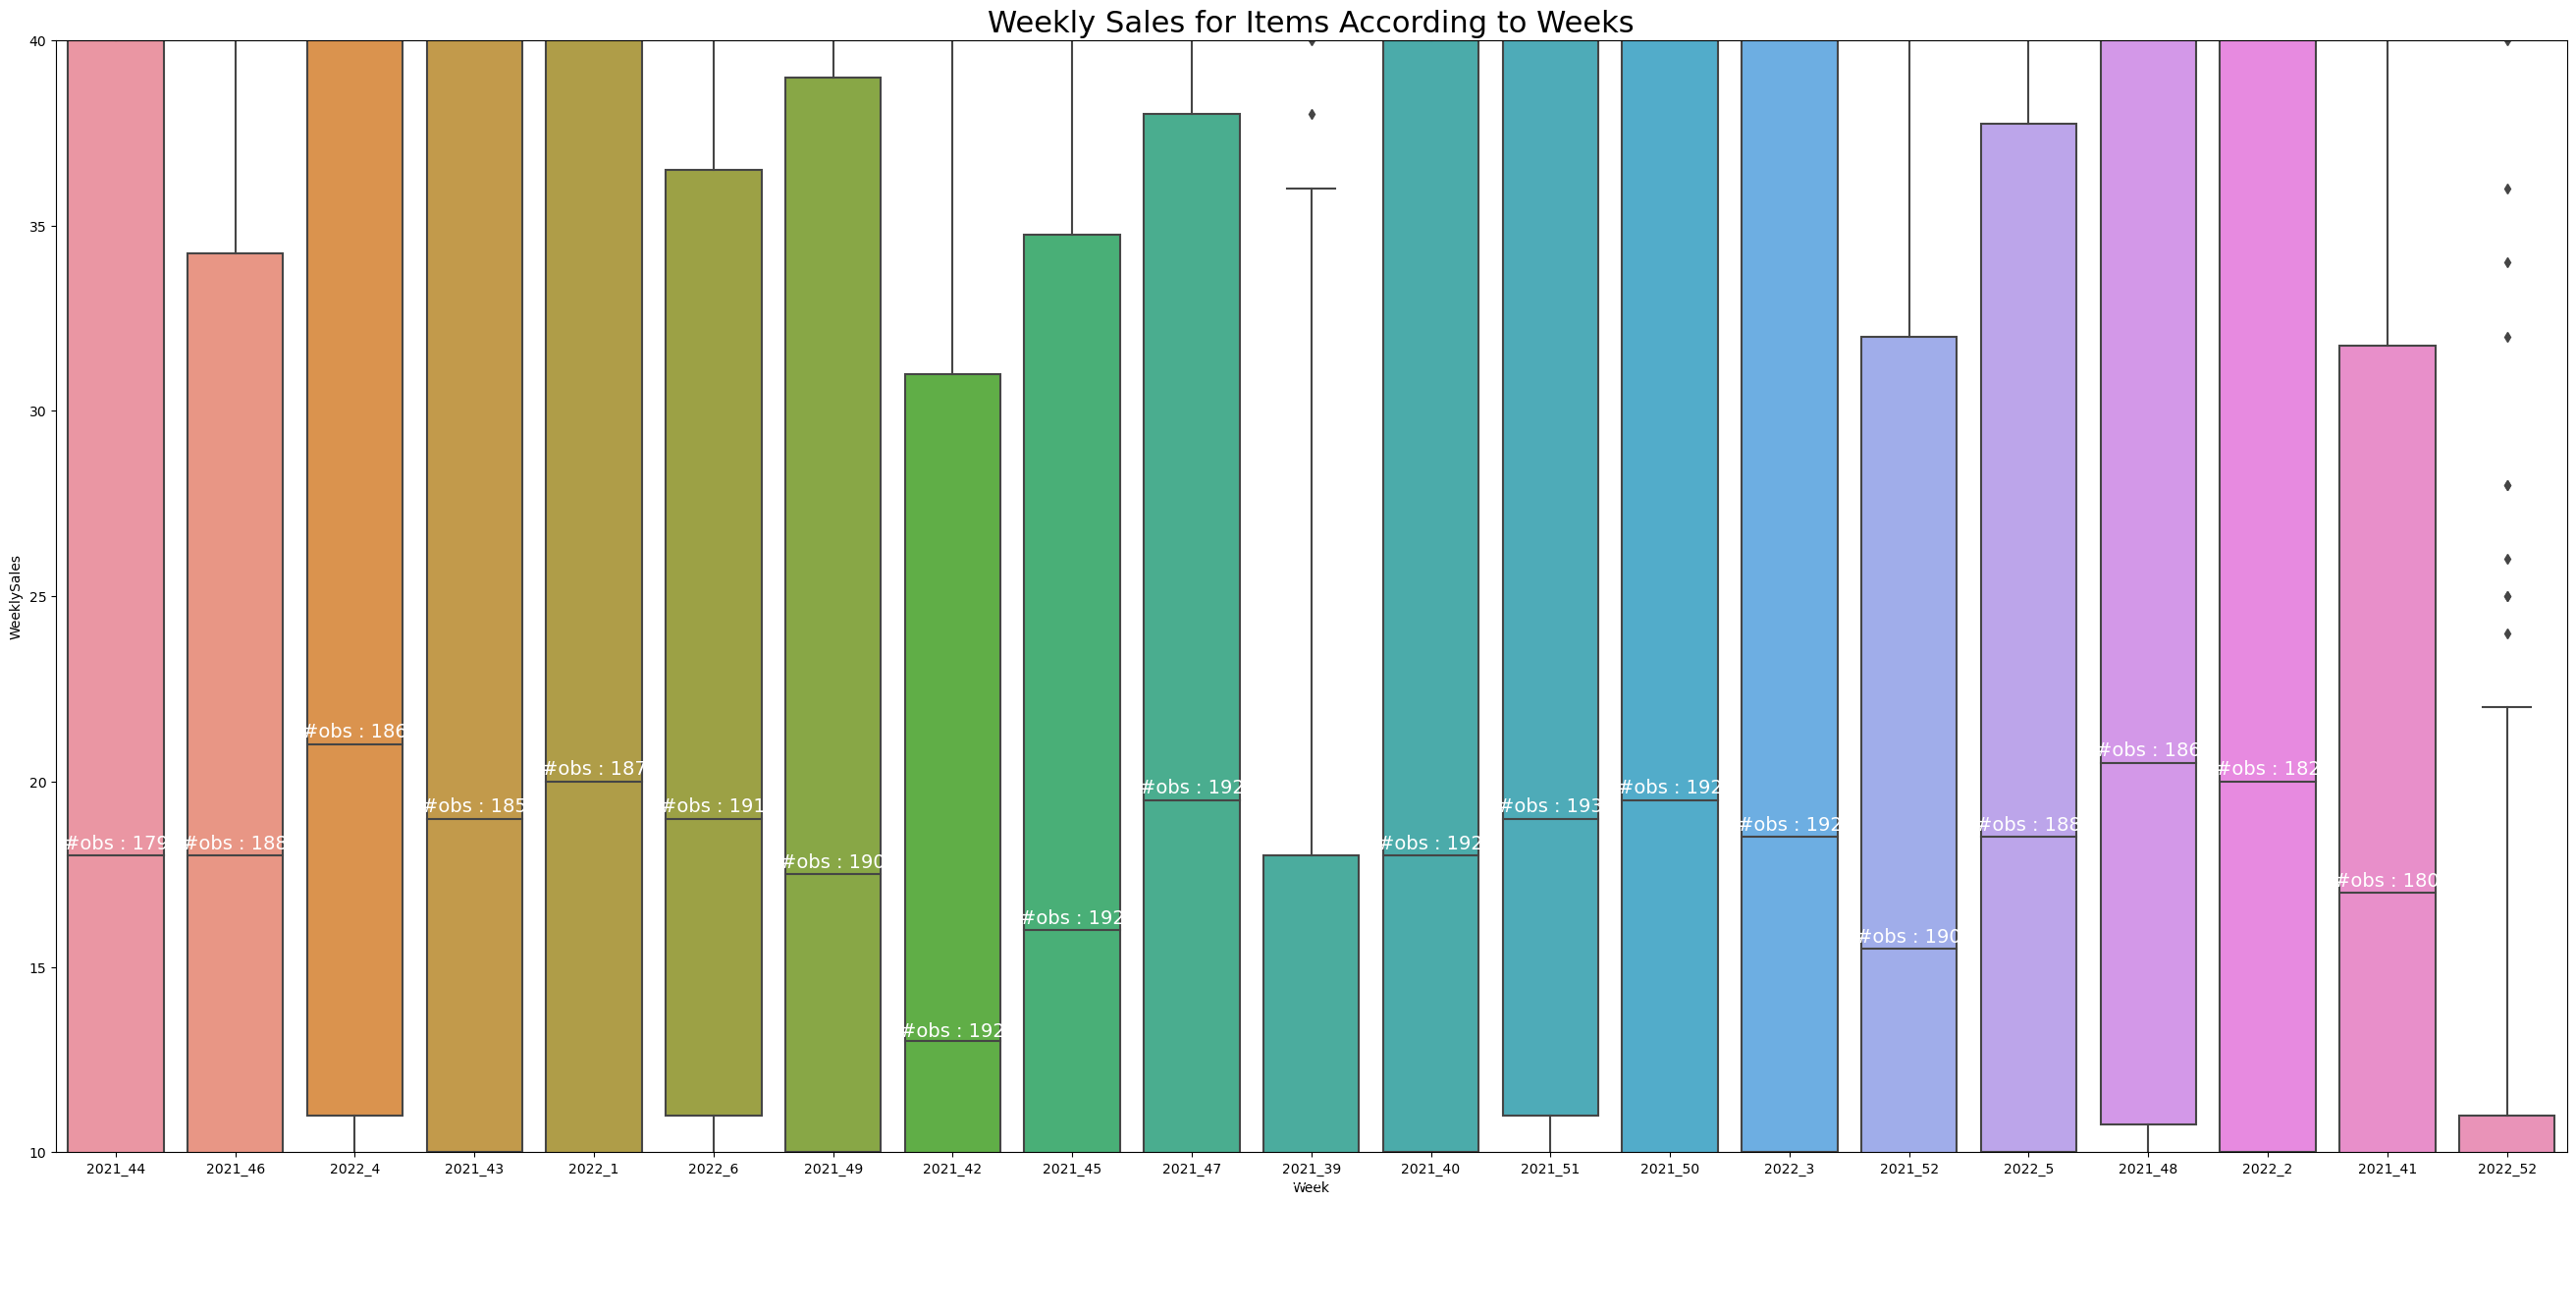

In [35]:
# Draw Plot
import seaborn as sns

plt.figure(figsize=(33,15), dpi= 100)
sns.boxplot(x='Week', y='WeeklySales', data=outTrain, notch=False)

# Add N Obs inside boxplot (optional)
def add_n_obs(outTrain,group_col,y):
    medians_dict = {grp[0]:grp[1][y].median() for grp in outTrain.groupby(group_col)}
    xticklabels = [x.get_text() for x in plt.gca().get_xticklabels()]
    n_obs = outTrain.groupby(group_col)[y].size().values
    for (x, xticklabel), n_ob in zip(enumerate(xticklabels), n_obs):
        plt.text(x, medians_dict[xticklabel]*1.01, "#obs : "+str(n_ob), horizontalalignment='center', fontdict={'size':14}, color='white')

add_n_obs(outTrain,group_col='Week',y='WeeklySales')    

# Decoration
plt.title('Weekly Sales for Items According to Weeks', fontsize=22)
plt.ylim(10, 40)
plt.show()

In [36]:
#! pip install squarify
import squarify 

### 2) Itemcode vs Demanded Items Weekly

**In order to grasp most demanded Items in Weekly Sales**

`Use of TreeMap.`


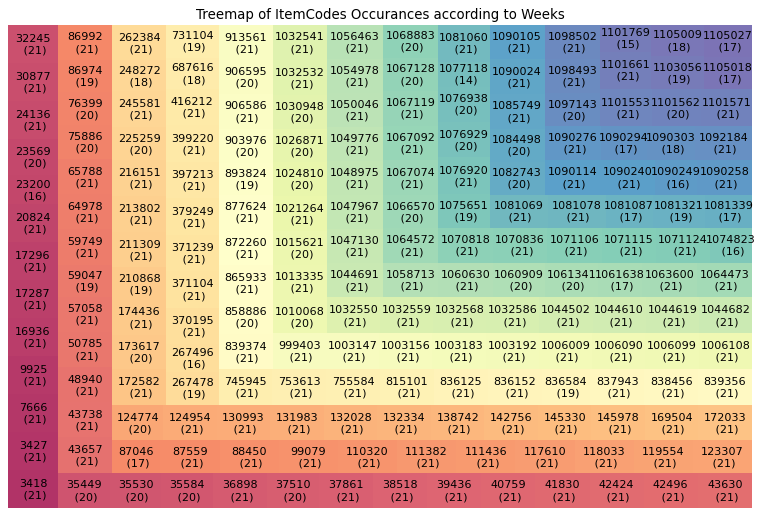

In [37]:
# Prepare Data
df = outTrain.groupby('ItemCode').size().reset_index(name='counts')
labels = df.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
sizes = df['counts'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

# Draw Plot
plt.figure(figsize=(12,8), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

# Decorate
plt.title('Treemap of ItemCodes Occurances according to Weeks')
plt.axis('off')
plt.show()

In [38]:
ItemSale=outTrain.groupby('ItemCode').sum()

In [39]:
ItemSale=ItemSale.reset_index()

In [40]:
#del ItemSale["index"]

In [41]:
ItemSale

,ItemCode,WeeklySales
0,3418,1268
1,3427,850
2,7666,1673
3,9925,238
4,16936,903
...,...,...
189,1101769,222
190,1103056,294
191,1105009,131
192,1105018,123


In [42]:
ItemSale['ItemCode']= ItemSale['ItemCode'].astype(object)

In [43]:
ItemSale.dtypes

ItemCode       object
WeeklySales     int64
dtype: object

### 3) Itemcode vs Number of Total Sales Weekly

**In order to grasp most demanded Items **

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


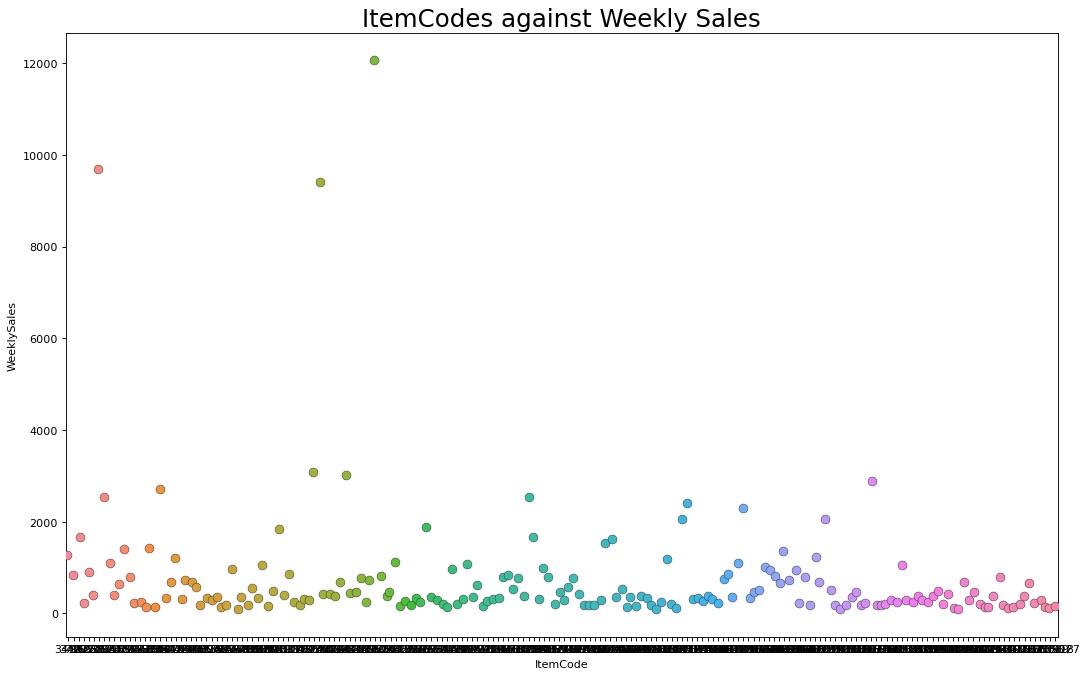

In [44]:
y = ItemSale.WeeklySales
x = ItemSale['ItemCode']

# Draw Stripplot
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)    
sns.stripplot(x, y, jitter=0.25, size=8, ax=ax, linewidth=.5)

# Decorations
plt.title('ItemCodes against Weekly Sales', fontsize=22)
plt.show()

In [54]:
del test["CategoryCode"]

In [55]:
test

,ItemCode,Week,PredictedSales
0,43738,w4,NaN
1,1006090,w1,NaN
2,1076929,w4,NaN
3,1081321,w3,NaN
4,216151,w4,NaN
...,...,...,...
372,1101571,w1,NaN
373,1090258,w4,NaN
374,906595,w1,NaN
375,32245,w1,NaN


In [60]:
# adding column with constant value Initially
test['PredictedSales'] = pd.Series([0 for x in range(len(test.Week))])

In [61]:
test.head(5)

,ItemCode,Week,PredictedSales
0,43738,w4,0
1,1006090,w1,0
2,1076929,w4,0
3,1081321,w3,0
4,216151,w4,0


In [62]:
outTrain.head(10)

,ItemCode,Week,WeeklySales
0,117610,2021_44,65
1,1067092,2021_44,204
2,815101,2021_44,18
3,172033,2021_44,178
4,1067074,2021_44,32
5,1071106,2021_44,25
6,30877,2021_44,72
7,877624,2021_44,31
8,1098493,2021_44,12
9,1048975,2021_44,8


## Train the Model

In [64]:
labels = outTrain.ItemCode

In [67]:
Outtrain=outTrain[["Week","WeeklySales"]]

In [68]:
X_train, X_test, y_train, y_test = train_test_split(Outtrain, labels, test_size=0.2, random_state = 2)

*   15 fold cross validation. Multiply by -1 to make values positive.

`Used median absolute error to learn how many trips my predictions are off by.`


In [69]:
def scoring(clf):
    scores = cross_val_score(clf, X_train, y_train, cv=15, n_jobs=1, scoring = 'neg_median_absolute_error')
    print (np.median(scores) * -1)

In [76]:
rfr = RandomForestRegressor(n_estimators = 55,
                            min_samples_leaf = 3,
                            random_state = 2)
scoring(rfr)

435562.00935064943


In [77]:
gbr = GradientBoostingRegressor(learning_rate = 0.12,
                                n_estimators = 150,
                                max_depth = 8,
                                min_samples_leaf = 1,
                                random_state = 2)
scoring(gbr)

427491.1034071158


In [78]:
dtr = DecisionTreeRegressor(min_samples_leaf = 3,
                            max_depth = 8,
                            random_state = 2)
scoring(dtr)

434562.6315789474


In [79]:
abr = AdaBoostRegressor(n_estimators = 100,
                        learning_rate = 0.1,
                        loss = 'linear',
                        random_state = 2)
scoring(abr)

434417.0562730627


In [84]:
#Train and make predictions with the best models.
rfr = rfr.fit(X_train, y_train)
gbr = gbr.fit(X_train, y_train)

rfr_preds = rfr.predict(X_test)
gbr_preds = gbr.predict(X_test)

#Weight the top models to find the best prediction
final_preds = rfr_preds*0.47 + gbr_preds*0.53
print ("Sales Predict Errors:", median_absolute_error(y_test, final_preds))

Sales Predict Errors: 422665.68903431087
